In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats as stats
import healpy as hp
%matplotlib inline
%config InlineBackend.figure_format='retina'
from SphericalDiff import *
from tqdm import tqdm_notebook as tqdm
from IPython.utils import io

In [2]:
Nside=128
Npix=hp.nside2npix(Nside)
Ampl=1e-5
Sigmal=100

In [3]:
# (theta, phi) -> (x,y,z)
def Ang2Vec(theta,phi):
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

In [4]:
def Cell(ells, ampl=Ampl, sigmal=Sigmal):
    return ampl*np.exp(-ells**2/(sigmal**2))

def Xi(theta, ampl=Ampl, sigmal=Sigmal):
    return ampl*sigmal**2/(4*np.pi)*np.exp((-theta**2*sigmal**2)/4)

In [5]:
#Make gaussian kappa with amplitude and sigma
## let's make a full sky map of gaussiana
def setup_kappa(ampl=1e-8, sigmal=100):
    ells=np.arange(3*Nside)
    Cl=Cell(ells, ampl, sigmal)
    kappa=hp.synfast(Cl,Nside)
#     kappa = np.ones(Npix)*ampl
    ## now multiply with a Gaussian taper:
    theta,phi=hp.pix2ang(Nside,np.arange(Npix))
    dec=theta-np.pi/2
    phi[phi>np.pi]=phi[phi>np.pi]-2*np.pi
    kappa*=np.exp(-(dec**2+phi**2)/(2*0.1**2))    
    kappa=SphericalMap(kappa)
    return kappa

In [6]:
# Distribute points in a box of size=(.1 radians)^2 and then displace them with the kappa
def setup_points(kappa, N, size=0.1):
    theta=np.arccos(np.random.uniform(-1*size,1*size,N))
    phi=np.random.uniform(-size,size,N)
    thetap,phip=kappa.DisplaceObjects(theta,phi);
    mpoints = np.array([thetap, phip]).T
    tpoints = np.array([theta, phi]).T
    return tpoints, mpoints

In [7]:
# Given original points, displaced points, and cutoff radius, generate the data vector and associated noise
def make_kappa(tpoints, mpoints, sradius, noiseofs=0.0, noisemult=1.0):
    new_kappa = []
    new_noise = []
    noisevar = []
    id1 = []
    id2 = []
    num_dots = len(tpoints)
    for i in tqdm(range(num_dots)):
        for j in range(i):
            vit = Ang2Vec(*tpoints[i])
            vjt = Ang2Vec(*tpoints[j])
            true_dist = np.linalg.norm(vit - vjt)
            if true_dist < sradius:
                id1.append(i)
                id2.append(j)
                vim = Ang2Vec(*mpoints[i])
                vjm = Ang2Vec(*mpoints[j])
                mod_dist = np.linalg.norm(vim - vjm)
                noise_rms = noiseofs+noisemult*true_dist
                noise_sig = noise_rms*np.random.normal(0,1)
                noisevar.append(noise_rms**2)
                new_kappa.append((mod_dist - true_dist)/true_dist)
                new_noise.append(noise_sig)
    new_kappa=np.array(new_kappa)
    new_noise=np.array(new_noise)
    noisevar=np.array(noisevar)
    return id1, id2, new_kappa, new_noise, noisevar

In [49]:
# Generate clte/cltt and clte/sqrt plots given the CLs
# Can choose to keep or remove monopole & dipole
def make_plots(true, reconstruct, plot, title = "method", cut_dipole=True):
    maxl = (3*Nside - 1)
    cltt = hp.anafast(true, true, lmax=maxl)
    clte = hp.anafast(true, reconstruct, lmax=maxl)
    clee = hp.anafast(reconstruct, reconstruct, lmax=maxl)
    if cut_dipole:
        plot1 = (clte/cltt)[2:]
        plot2 = (clte/np.sqrt(cltt*clee))[2:]
    else:
        plot1 = (clte/cltt)
        plot2 = (clte/np.sqrt(cltt*clee))
        
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(plot1)
        ax[0].set_title(title + " - clte/cltt")
        ax[1].plot(plot2)
        ax[1].set_title(title + " - clte/sqrt")
        
    return plot1, plot2

In [9]:
# Make a diagonal sparse matrix which has values of 1/noise
def make_diag_inverse(diag):
    size = len(diag)
    cleaned_diag = [1/n if n!=0 else 1 for n in diag]
    dia_n = sp.sparse.dia_matrix((cleaned_diag, 0), shape=(size,size)).tocsc()
    return dia_n

In [10]:
# Setup needed for midpoint method
def mid_setup(id1, id2, mpoints):
    p1 = []
    p2 = []
    for i in tqdm(range(len(id1))):
        p1.append(Ang2Vec(*mpoints[id1[i]]))
        p2.append(Ang2Vec(*mpoints[id2[i]]))
    np1 = np.array(p1)
    np2 = np.array(p2)
    return np1, np2

In [11]:
#Setup needed for optimal method
def optimal_setup(tpoints, sradius = 1/180*np.pi):
#     pixid = np.array(list(set(hp.ang2pix(Nside, tpoints[:,0], tpoints[:,1]))))
    points = Ang2Vec(tpoints[:,0], tpoints[:,1]).T
    bigid = np.array([hp.query_disc(Nside, p, sradius) for p in points])
    pixid = np.array(list(set(np.concatenate(bigid, axis=0))))
#     pixid = np.array(list(set(hp.get_all_neighbours(Nside, hp.ang2pix(Nside, tpoints[:,0], tpoints[:,1])).flatten())))
    hpx = {}
    pxd = {}
    for c,v in enumerate(pixid):
        hpx[v] = hp.pix2vec(Nside,v)
        pxd[v] = c
    hpix=hpx
    pixdict = pxd
    sigma=np.sqrt(4*np.pi/(12*Nside**2))        
    sigweight = 2*sigma**2

    return pixid, hpix, pixdict, sigweight

In [12]:
def prime_setup(mpoints):
    hpx = {}
    pxd = {}
    p1, p2 = mid_setup(id1, id2, mpoints)
    m1 = (p1+p2)*.5
    mid = m1/np.linalg.norm(m1)
    hp_points = hp.vec2pix(Nside, mid.T[0], mid.T[1], mid.T[2])
#     allpoints = np.concatenate((hp_points, pixid))
#     iterpoints = np.array(list(set(allpoints)))
    iterpoints = np.array(list(set(hp_points)))
    for c,v in enumerate(iterpoints):
        hpx[v] = hp.pix2vec(Nside,v)
        pxd[v] = c
    return iterpoints, hpx, pxd

In [13]:
# Concise midpoint estimator
def big_mid(p1, p2, kappa, noisevar):
    m1 = (p1+p2)*.5
    mid = m1/np.linalg.norm(m1)
    hp_points = hp.vec2pix(Nside, mid.T[0], mid.T[1], mid.T[2])
    signal = np.bincount(hp_points, weights=kappa/noisevar, minlength=Npix)
    weight = np.bincount(hp_points, weights=1/noisevar, minlength=Npix)
    return signal, weight

In [44]:
#Optimal estimator
def optimal(qid1, qid2, kappa, sradius, points, noisevar, pixid, pixdict, hpix):
    data = []
    rows = []
    columns = []
    Nd = len(kappa)
    Np = len(pixid)
    pixarea = hp.nside2pixarea(Nside, False)
    sigma=np.sqrt(4*np.pi/(12*Nside**2))        
    sigweight = 2*sigma**2

    for j in tqdm(range(Nd)):
        qtheta1=points[qid1[j]][0]
        qphi1=points[qid1[j]][1]
        qtheta2=points[qid2[j]][0]
        qphi2=points[qid2[j]][1]
        
        q1 = Ang2Vec(qtheta1, qphi1)
        q2 = Ang2Vec(qtheta2, qphi2)
        rad = np.arccos(np.dot(q1,q2))
        qrad = rad if rad > sradius else sradius
        neipixels1=hp.query_disc(Nside, q1, qrad)
        neipixels2=hp.query_disc(Nside, q2, qrad)
        
        s = np.intersect1d(neipixels1, neipixels2)
        ss = set(s)
        smols = np.array([*ss.intersection(pixid)])
        jthrow = [pixdict[l] for l in smols]
        if (smols.shape[0] == 0):
            continue
        ms = np.array([hpix[x] for x in smols])

        d1 = q1 - ms
        d2 = q2 - ms

        norm1 = np.einsum('ij,ij->i', d1, d1)       #Faster way to calculate norms
        norm2 = np.einsum('ij,ij->i', d2, d2)

        resp1=norm1*(1-np.exp(-norm1/(2*sigweight)))
        resp2=norm2*(1-np.exp(-norm2/(2*sigweight)))

        drr = (d1.T*resp1).T - (d2.T*resp2).T
        dr = d1 - d2

#         totresponse = -2*np.sqrt(np.einsum('ij,ij->i', drr, drr))/np.sqrt(np.einsum('ij,ij->i',dr,dr))
        totresponse = -4*pixarea/(norm1+norm2)
        data += list(totresponse)
        rows += [j]*len(jthrow)
        columns += jthrow

    print("Creating A matrix...")
    A = sp.sparse.csr_matrix((data, (rows, columns)), shape=(Nd, Np))
    return A

In [45]:
#Optimal estimator
def optimal_prime(qid1, qid2, kappa, sradius, points, noisevar, pixid, pixdict, hpix):
    data = []
    rows = []
    columns = []
    Nd = len(kappa)
    Np = len(pixid)
    pixarea = hp.nside2pixarea(Nside, False)
    sigma=np.sqrt(4*np.pi/(12*Nside**2))        
    sigweight = 2*sigma**2
    for j in tqdm(range(Nd)):
        qtheta1=points[qid1[j]][0]
        qphi1=points[qid1[j]][1]
        qtheta2=points[qid2[j]][0]
        qphi2=points[qid2[j]][1]
        
        q1 = Ang2Vec(qtheta1, qphi1)
        q2 = Ang2Vec(qtheta2, qphi2)
        rad = np.arccos(np.dot(q1,q2))
        qrad = sradius if rad > sradius else rad
        neipixels1=hp.query_disc(Nside, q1, qrad)
        neipixels2=hp.query_disc(Nside, q2, qrad)
        
        s = np.intersect1d(neipixels1, neipixels2)
        ss = set(s)
        smols = np.array([*ss.intersection(pixid)])
        jthrow = [pixdict[l] for l in smols]
        if (smols.shape[0] == 0):
            continue
        ms = np.array([hpix[x] for x in smols])

        d1 = q1 - ms
        d2 = q2 - ms

        norm1 = np.einsum('ij,ij->i', d1, d1)       #Faster way to calculate norms
        norm2 = np.einsum('ij,ij->i', d2, d2)
        
        resp1=norm1*(1-np.exp(-norm1/(2*sigweight)))
        resp2=norm2*(1-np.exp(-norm2/(2*sigweight)))

        drr = (d1.T*resp1).T - (d2.T*resp2).T
        dr = d1 - d2

#         totresponse = -2*np.sqrt(np.einsum('ij,ij->i', drr, drr))/np.sqrt(np.einsum('ij,ij->i',dr,dr))
        totresponse = -4*pixarea/(norm1+norm2)*np.sqrt(noisevar[j])
        data += list(totresponse)
        rows += [j]*len(jthrow)
        columns += jthrow

    print("Creating A matrix...")
    A = sp.sparse.csr_matrix((data, (rows, columns)), shape=(Nd, Np))
    return A

In [16]:
# Following COBE method of mapmaking
def cobe_makemap(A, Ninv, x):
    print("Making map")
    At = A.T
    print("Calculating W....")
    X = At@Ninv@A
    Y = At@Ninv@x
#     cmap = optimal_makemap(X, Y)[0]
    return X, Y

In [17]:
def iterative_cobe(A, Ninv, kap, n=10):
    At = A.T
    print("Start iterations")
    x_orig = cobe_makemap(A, Ninv, kap)
    for i in tqdm(range(n)):
        x_next = x_orig+At@Ninv@kap - At@Ninv@A@x_orig
        x_orig = x_next
    return x_next

In [18]:
def iterative_cobe2(A, Ninv, kap, n=10):
    At = A.T
    atai = sp.sparse.linalg.inv(At@A)
    t1 = At@kap
    t2 = atai@t1
    t3 = A@t2
    z = t3 - kap
    print("Start iterations")
    x_orig = cobe_makemap(A, Ninv, kap)
    for i in tqdm(range(n)):
        x_next = x_orig + At@Ninv@z - (At@Ninv@A)@x_orig
        x_orig = x_next
    return x_next

In [19]:
# Following WIENER 2
def wiener2_makemap(A, Ninv, Sinv, x):
    print("Making map")
    At = A.T
    print("Calculating W....")
    X = Sinv + At@Ninv@A
    Y = At@Ninv@x
    wmap = optimal_makemap(X, Y)[0]
    return wmap

In [20]:
# Following TE97
def te97_makemap(A, Ninv, Sinv, x):
    print("Making map")
    At = A.T
    print("Calculating W....")
    X = Sinv + At@Ninv@A
    Y = At@Ninv
    ya = Y@A
    print("Making lambda")
    inv_lambdas = X.diagonal()/ya.diagonal()
    clean_lambs = np.array(list(map(lambda x: x if ~np.isnan(x) else 0, inv_lambdas)))
    big_lambda = make_diag_inverse(clean_lambs)
    print("Made lambda")
    rhs = big_lambda@X
    lhs = Y@x
    temap = optimal_makemap(rhs, lhs)[0]
    return temap

In [21]:
def iterative_wiener2(A, Ninv, Sinv, kap, n=10):
    At = A.T
    atai = sp.sparse.linalg.inv(At@A)
    print("Start iterations")
    t1 = At@kap
    t2 = atai@t1
    t3 = A@t2 - kap
    print("got to t3")
    t4 = At@Ninv@t3
    t5 = Sinv@atai@t1
    print("got past t5")
    u = t4 - t5
    x_orig = wiener2_makemap(A, Ninv, Sinv, kap)
    for i in tqdm(range(n)):
        x_next = x_orig + u - (Sinv+At@Ninv@A)@x_orig
        x_orig = x_next
    return x_next

In [22]:
# Wrapper function for scipy sparse lsmr
def optimal_makemap(A, b):
    print("running solver")
    mp = sp.sparse.linalg.lsmr(A,b)
    return mp

In [23]:
# Create map given signal and weight
def mid_makemap(s,w):
    fullmap = s/w
    midmap = np.array(list(map(lambda x: x if ~np.isnan(x) else 0, fullmap)))
    return midmap

In [24]:
# Given a small array of relevant pixels (pixid), create a full sized kappa map.
def small2big(data, pixd):
    big = np.zeros(Npix)
    big[pixd] = data
    return big

In [25]:
# COBE map
def cobe(A, kappa, noise):
    N = make_diag_inverse(noise)
    dat = cobe_makemap(A, N, kappa)
#     cobemap = small2big(dat)
#     c1, c2 = make_plots(true_kap, cobemap, False, 'COBE')
    return dat

In [26]:
def just_wienermap(A, kappa, noise, pxd):
    Ninv = make_diag_inverse(noise)
#     Sinv = make_diag_inverse(Xi(0)*np.ones(A.shape[1]))
    Sinv = make_diag_inverse(np.var(kappa)*np.ones(A.shape[1]))
#     Sinv = make_diag_inverse(kappa)
    dat = wiener2_makemap(A, Ninv, Sinv, kappa)
#     dat = te97_makemap(A, Ninv, Sinv, kappa)
#     dat = iterative_wiener2(A, Ninv, Sinv, kappa, 10)
    wienermap = small2big(dat, pxd)
    return wienermap

In [27]:
def just_midmap(id1, id2, mpoints, kappa, noisevar):
    np1, np2 = mid_setup(id1, id2, mpoints)
    s,w = big_mid(np1, np2, kappa, noisevar)
    midmap = mid_makemap(-s,w)
    return midmap

In [28]:
def cost_function(A, kappa):
    J = lambda x : np.linalg.norm(A@x-kappa)**2
    return J

In [29]:
def grad_J(A, kappa):
    nabla = lambda x: 2*A.T@(A@x-kappa)
    return nabla

In [30]:
def just_adam(A, kappa, theta_0, eta=1e-4, epsilon=1e-8, beta1 = .9, beta2 = .999,  iterations=1):
    J = cost_function(A, kappa)
    Gtt = np.zeros(A.shape[1])
    c0 = J(theta_0)
    
    xs = [Gtt]
    cs = [c0]
    ms = [Gtt]
    vs = [Gtt]
    kmax = kappa.shape[0]
    for i in range(iterations):
        test_i = np.random.randint(0, kmax, size=int(np.floor(kmax/10)))
        for ind,j in tqdm(enumerate(test_i)):
            x0 = xs[-1]
            m0 = ms[-1]
            v0 = vs[-1]
            
            real_ind = i*kmax+ind
            
            grad = grad_J(A[j], kappa[j])
            gt = grad(x0)
            
            mt = beta1*m0 + (1 - beta1)*gt
            vt = beta2*v0 + (1 - beta2)*gt**2
            
            mhat = mt/(1 - beta1**real_ind)
            vhat = vt/(1 - beta2**real_ind)
            
            delta_x = -eta/(np.sqrt(vhat) + epsilon)*mhat
            xprime = x0 + delta_x
            cs.append(J(xprime))
            xs.append(xprime)
            ms.append(mt)
            vs.append(vt)
    return xs, cs

In [31]:
def just_fgd(A, kappa, theta_0, eta=1e-5, iterations=500):
    J = cost_function(A, kappa)
    grad = grad_J(A, kappa)
    xs = [theta_0]
    c0 = J(theta_0)
    cs = [c0]
    for i in tqdm(range(iterations)):
        x0 = xs[-1]
        xprime = x0 - eta*grad(x0)
        cs.append(J(xprime))
        xs.append(xprime)
    return xs, cs

In [32]:
#Full ADAM map
def adam(A, kappa, eta=1e-5, epsilon=1e-8, beta1=.9, beta2=.999, iters=1):
    thet0 = np.zeros(A.shape[1])
    maps, costs = adam_method(A, kappa, thet0, eta=1e-6, epsilon=1e-8, beta1=.9, beta2=.999, iterations=iters)
    fin_map = maps[-1]
    addel_map = small2big(fin_map)
    a1, a2 = make_plots(true_kap, addel_map, False, 'ADAM')
    return a1, a2

In [34]:
#Full Gradient Descent map
def fgd(A, kappa, noisevar, pxd, tk, iters=500, eta=1e-5):
    thet0 = np.zeros(A.shape[1])
    spnoise = sp.sparse.spdiags(1/np.sqrt(noisevar), 0, len(noisevar), len(noisevar))
    aprime = spnoise * A
    maps, costs = just_fgd(aprime, kappa, thet0, eta=eta, iterations=iters)
    fin_map = maps[-1]
    fgd_map = small2big(fin_map, pxd)
    f1, f2 = make_plots(tk, fgd_map, False, 'FGD', cut_dipole=True)
    return f1, f2

In [35]:
# Wiener map
def wiener(A, kappa, noise, pxd, tk):
    wienermap = just_wienermap(A, kappa, noise, pxd)
    w1, w2 = make_plots(tk, wienermap, False, 'Wiener', cut_dipole=True)
    return w1, w2

In [36]:
# Midpoint map 
def mid(id1, id2, points, kappa, noisevar, tk):
    midmap = just_midmap(id1, id2, points, kappa, noisevar)
    m1, m2 = make_plots(tk, midmap, False, 'Midpoint', cut_dipole=True)
    return m1, m2

In [37]:
# LSMR map method
def direct_lsmr(A, kappa):
    m = optimal_makemap(A, kappa)[0]
    optmap = small2big(m)
    optmap_test = optmap*-1
    l1, l2 = make_plots(true_kap, optmap_test, False, 'lsmr')
    return l1, l2

In [38]:
def size_filter(qid1, qid2, points, cutoff=.1):
    acceptable = np.zeros(len(qid1))
    for i, v in enumerate(qid1):
        p1 = Ang2Vec(*points[v])
        p2 = Ang2Vec(*points[qid2[i]])
        dist = np.linalg.norm(p1-p2)
        if dist > cutoff:
            acceptable[i] = 1
    return acceptable

In [39]:
def sevearl_ls(id1, id2, points, kappa):
    cutoffs = np.array([0, .01, .03, .05, .07])
    srads = np.array([.01, .03, .05, .07, .09])
    pixid, hpix, pixdict, sigweight= optimal_setup(points, .1)
    maps = np.zeros((5, hp.nside2npix(Nside)))
    for i,v in enumerate(cutoffs):
        l = size_filter(id1, id2, points, cutoff=v).astype('bool')
        sradius = 1/180*np.pi
        lid1 = np.array(id1)[l]
        lid2 = np.array(id2)[l]
        A = optimal_prime(lid1, lid2, kappa[l], srads[i], mpoints, noisevar, pixid)
        thet0 = np.zeros(A.shape[1])
        ms, _ = just_fgd(A, kappa[l], thet0, eta=1e-6, iterations=1000)
        fin_map = small2big(ms[-1], pixid)
        maps[i] = fin_map
    return maps

In [40]:
# Use all 4 methods to create clte/cltt and clte/sqrt plots
def legend_plots(id1, id2, mpoints, f, k, n, pixd, l, tk, make_plot = True):
#     l1, l2 = direct_lsmr(f, k)
    w1, w2 = wiener(f, k[l], n[l], pixd, tk)
    m1, m2 = mid(id1, id2, mpoints, k, n, tk)
    f1, f2 = fgd(f, k[l], n[l], pixd, tk, 500, 1e-6)
    
    if make_plot:
        fig, ax = plt.subplots(1,2, figsize=(10,5))

        ax[0].plot(w1, label='wiener')
        ax[0].plot(m1, label='mid')
#         ax[0].plot(l1, label='lsmr')
        ax[0].plot(f1, label='fgd')
        ax[0].legend()
        ax[0].set_title("clte/cltt")
        ax[1].plot(w2, label='wiener')
        ax[1].plot(m2, label='mid')
#         ax[1].plot(l2, label='lsmr')
        ax[1].plot(f2, label='fgd')
        ax[1].legend()
        ax[1].set_title("clte/sqrt")

    return w1, w2, m1, m2, f1, f2
    

In [63]:
def mrun(amplitude, sigma, n=5, makeplots=True):
    sradius = 1/180*np.pi
    plots = np.zeros((6,3*Nside-2))
    for i in range(n):
        kappamap = setup_kappa(amplitude,sigma)
        tkap = kappamap.A
        tpoints, mpoints = setup_points(kappamap, 500, .1)
        id1, id2, kappa_noiseless, noise, noisevar = make_kappa(tpoints, mpoints, 7/180*np.pi,noiseofs=1e-3,noisemult=1)
        kappa=kappa_noiseless+noise
        pixid, hpix, pixdict, sigweight= optimal_setup(mpoints, 3*sradius)
        l = size_filter(id1, id2, mpoints, .015).astype('bool')
        lid1 = np.array(id1)[l]
        lid2 = np.array(id2)[l]
        A = optimal_prime(lid1, lid2, kappa[l], 5*sradius , mpoints, noisevar, pixid, pixdict, hpix)
        plots += legend_plots(id1, id2, mpoints, A, kappa, noisevar, pixid, l, tkap, False)
        
    w1, w2, m1, m2, f1, f2 = plots/n
    
    if makeplots:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
#         ax[0].plot(l1, label='lsmr')
        ax[0].plot(w1, label='wiener')
        ax[0].plot(m1, label='mid')
        ax[0].plot(f1, label='fgd')
        ax[0].legend()
        ax[0].set_title("clte/cltt")
#         ax[1].plot(l2, label='lsmr')
        ax[1].plot(w2, label='wiener')
        ax[1].plot(m2, label='mid')
        ax[1].plot(f2, label='fgd')
        ax[1].legend()
        ax[1].set_title("clte/sqrt")

In [47]:
# Create kappa and clean the array
# setup_kappa(amplitude, sigma)
Ampl=1e-5
Sigmal=100
kappamap = setup_kappa(Ampl,Sigmal)
true_kap = kappamap.A

In [ ]:
%%capture
# Distribute points using kappamap
# setup_points(kappamap, size of side of square Number of points)
tpoints, mpoints = setup_points(kappamap, 500, .1)

In [ ]:
hp.gnomview(kappamap.A,reso=10)
plt.plot(tpoints[:50,0]-np.pi/2,tpoints[:50,1],'r.',markersize=2)
plt.plot(mpoints[:50,0]-np.pi/2,mpoints[:50,1],'y.',markersize=2)

In [ ]:
# Creates data vector and noise vector
# make_kappa(tpoints, mpoints, search_radius)
id1, id2, kappa_noiseless, noise, noisevar = make_kappa(tpoints, mpoints, 7/180*np.pi,noiseofs=1e-3,noisemult=1)
kappa=kappa_noiseless+noise

In [ ]:
# maybe_maps = sevearl_ls(id1, id2, mpoints, kappa)

In [ ]:
sradius = 1/180*np.pi

In [ ]:
pixid, hpix, pixdict, sigweight= optimal_setup(mpoints, 3*sradius)

In [ ]:
# pixid, hpix, pixdict = prime_setup(mpoints)

In [ ]:
l = size_filter(id1, id2, mpoints, sradius).astype('bool')

In [ ]:
lid1 = np.array(id1)[l]
lid2 = np.array(id2)[l]

In [ ]:
# Run optimal estimator
# optimal(id1, id2, kappa, search_radius for estimator, noise)
A = optimal_prime(lid1, lid2, kappa[l], 5*sradius , mpoints, noisevar, pixid, pixdict, hpix)
# A = optimal(id1, id2, kappa, 5*sradius, mpoints, noisevar, pixid, pixdict, hpix)

In [ ]:
wfm = just_wienermap(A, kappa[l], noisevar[l], pixid)

In [ ]:
make_plots(true_kap, wfm, True);

In [ ]:
res=A@kappamap.A[pixid]
plt.plot(res,kappa_noiseless[l],'b.')
stats.pearsonr(res, kappa_noiseless[l])

In [ ]:
w1, w2 = wiener(A, kappa[l], noisevar[l], pixid, true_kap)
# # # l1, l2 = direct_lsmr(A, kappa)
# m1, m2 = mid(id1, id2, mpoints, kappa, noisevar, true_kap)
# f1, f2 = fgd(A, kappa[l], noisevar[l], pixid, true_kap, 500)
# t1, t2 = make_plots(true_kap, ktest, False)
# a1, a2 = adam(A, kappa)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(w1, label='wiener')
ax[0].plot(m1, label='mid')
# ax[0].plot(f1, label='fgd')
# ax[0].plot(t1, label='best')
ax[0].legend()
ax[0].set_title("clte/cltt")
ax[1].plot(w2, label='wiener')
ax[1].plot(m2, label='mid')
# ax[1].plot(f2, label='fgd')
# ax[1].plot(t2, label='best')
ax[1].legend()
ax[1].set_title("clte/sqrt")

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
almp:  [[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
              nan           +nanj ...             nan           +nanj
              nan           +nanj             nan           +nanj]
 [ 6.12850298e-06+0.00000000e+00j -1.36983395e-04-2.34630058e-06j
   0.00000000e+00+0.00000000e+00j ...             nan           +nanj
              nan           +nanj             nan           +nanj]
 ...
 [-9.34836986e-11+0.00000000e+00j -1.18264216e-10-1.87544761e-13j
   8.97885946e-11+2.27593781e-11j ...  0.00000000e+00+0.00000000e+00j
              nan           +nanj             nan           +nanj]
 [-1.00809914e-10+0.00000000e+00j  8.784


Creating A matrix...
Making map
Calculating W....
running solver


/Users/pecom/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pecom/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


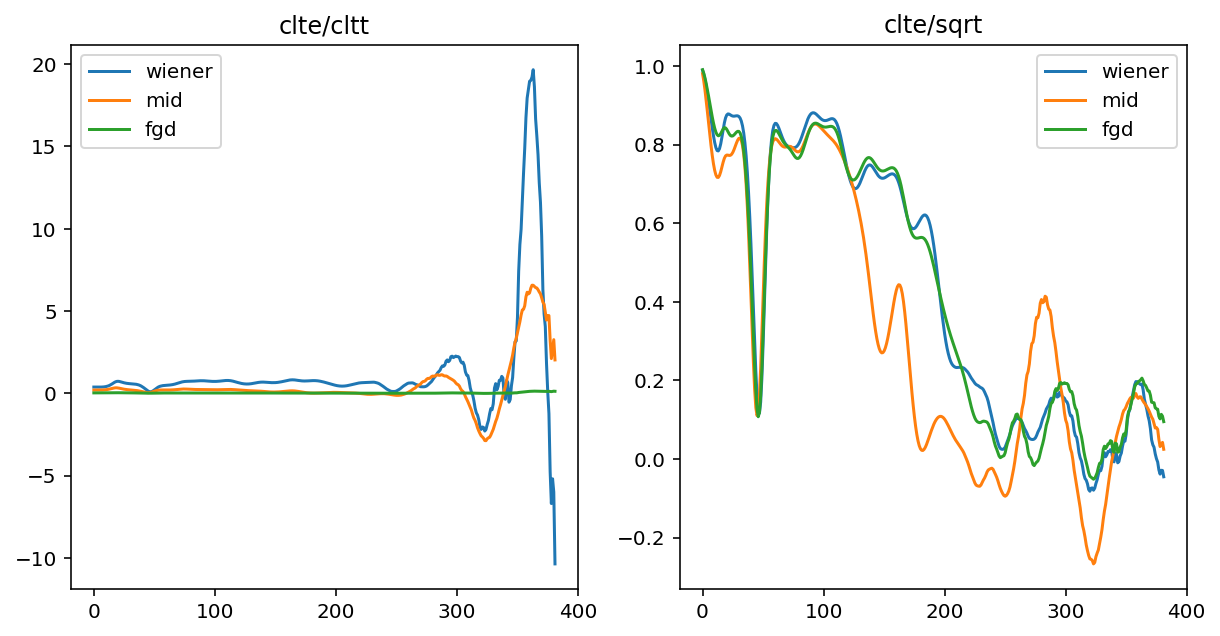

In [64]:
mrun(Ampl, Sigmal, n=1, makeplots=True)

In [ ]:
# Create plots
w1, w2, m1, m2, f1, f2 = legend_plots(id1, id2, mpoints, A, kappa, noisevar, pixid, l, true_kap, True)

In [ ]:
len(w2)

In [ ]:
_ = multi_run(1, 500, 7, 3, True, 1e-05, 100, 1e-3, 1)

In [ ]:
# a=1e-5 n=1e-8 wiener,cobe,lsmr fail
# a=1e-5 n=1e-10 wiener,cobe,lsmr fail
# a=1e-5 n=1e-5 wiener,cobe,lsmr fail
# a=1e-5 n=1e-3 wiener,cobe,lsmr fail
# a=1e-8 n=1e-3 lsmr fail
# a=1e-8 n=1e-5 all work!
# a=1e-8 n=1e-8 cobe, lsmr fail
# a=1e-8 n=1e-10 wiener fails

In [ ]:
s, w = big_mid(np1, np2, kappa, noisevar)
k = -mid_makemap(s,w)

In [ ]:
s,w = circ_mid(np1, np2, kappa, noisevar, 5/180*np.pi)
l = -mid_makemap(s,w)

In [ ]:
make_plots(true_kap, l, True);

In [ ]:
make_plots(true_kap, k, True);

In [ ]:
Ampl=1e-5
Sigmal=100

In [ ]:
runs = multi_run(1, 500, 5, 5, True, 1e-5,100,1e-2,1)

In [ ]:
np1, np2 = mid_setup(id1, id2, mpoints)
s,w = big_mid(np1, np2, kappa, noisevar)
midmap = mid_makemap(-s,w)

In [ ]:
np.nonzero(midmap)[0].shape

In [ ]:
len(pixid)

In [ ]:
acceptable = np.zeros(len(id1))
for i, v in enumerate(id1):
    p1 = Ang2Vec(*tpoints[v])
    p2 = Ang2Vec(*tpoints[id2[i]])
    dist = np.linalg.norm(p1-p2)
    acceptable[i] = dist

In [ ]:
plt.hist(acceptable)